# Imports

In [1]:
%load_ext autoreload
%autoreload 2

from dataloader.load_regression_data_from_arbitrary_gp import RegressionDataGeneratorArbitraryGP

2023-02-19 15:19:53.893394: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-19 15:19:54.542971: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-19 15:19:54.543036: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-19 15:19:54.543043: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make su

# DataGenerator

In [2]:
data_generator = RegressionDataGeneratorArbitraryGP(
    iterations=100,
    batch_size=32,
    min_num_context=3,
    max_num_context=20,
    min_num_target=2,
    max_num_target=10,
    min_x_val_uniform=-2,
    max_x_val_uniform=2,
    kernel_length_scale=0.4
)

In [3]:
(context_x, context_y, target_x), target_y = next(iter(data_generator.train_ds))

(<Figure size 800x500 with 1 Axes>, <AxesSubplot: >)

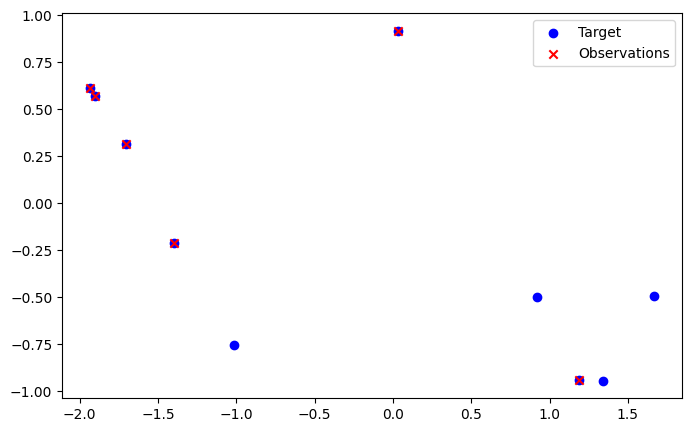

In [4]:
data_generator.plot_first_elt_of_random_batch()

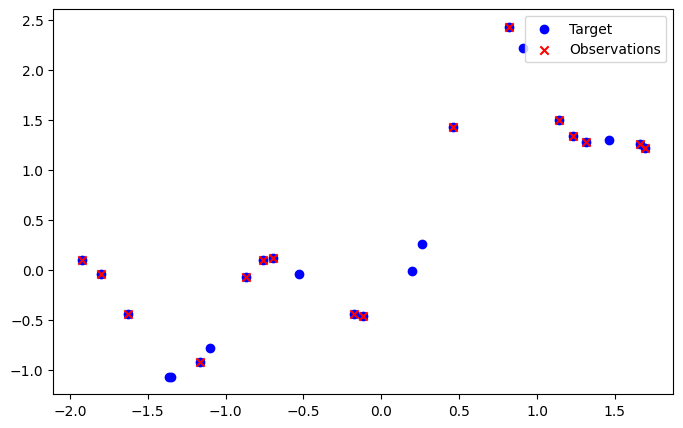

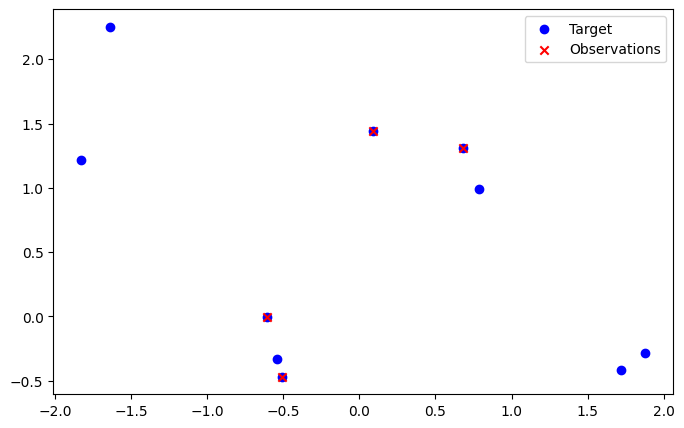

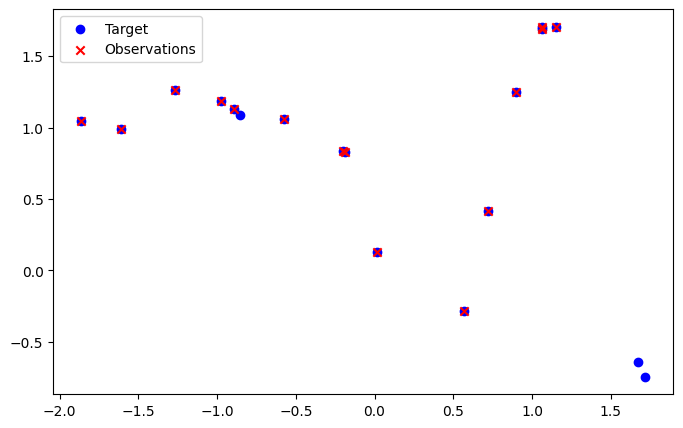

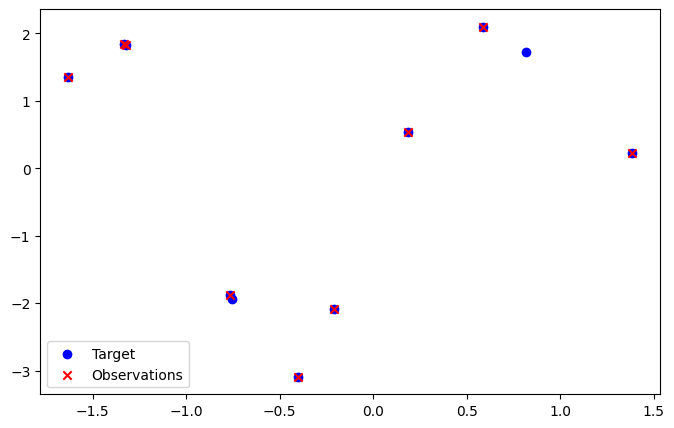

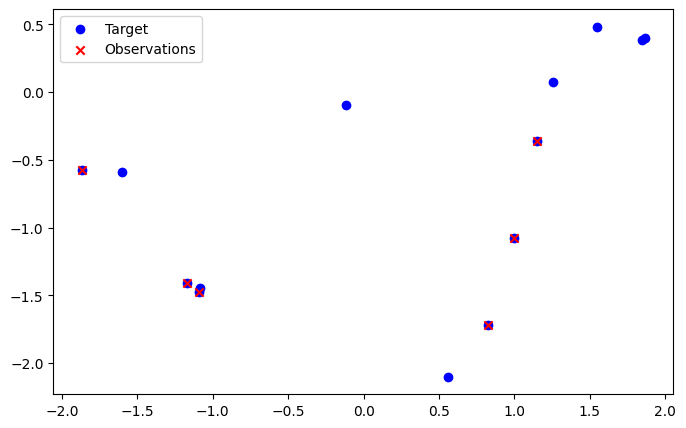

In [5]:
for (context_x, context_y, target_x), target_y in data_generator.train_ds.take(5):
    RegressionDataGeneratorArbitraryGP.plot_first_elt_of_batch(context_x, context_y, target_x, target_y)

In [6]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
from model import ConditionalNeuralProcess

encoder_dims = [500, 500, 500, 500]
decoder_dims = [500, 500, 500, 2]

def loss(target_y, pred_y):
    # Get the distribution
    mu, sigma = tf.split(pred_y, num_or_size_splits=2, axis=-1)
    dist = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)
    return -dist.log_prob(target_y)

model = ConditionalNeuralProcess(encoder_dims, decoder_dims)
model.compile(loss=loss, optimizer='adam')

In [8]:
model.fit(data_generator.train_ds, validation_data=data_generator.test_ds, epochs=2)

Epoch 1/2
100/100 [==============================] - 12s 119ms/step - loss: 1.0188 - val_loss: 1.1366
Epoch 2/2
100/100 [==============================] - 11s 114ms/step - loss: 0.9435 - val_loss: 1.1024


In [16]:
(context_x, context_y, target_x), target_y = next(iter(data_generator.test_ds.take(1)))

In [18]:
y_preds = model.predict((context_x, context_y, target_x))

1/1 [==============================] - 0s 43ms/step


In [35]:
y_preds.shape

(32, 409, 2)

In [21]:
target_y.shape

TensorShape([32, 409, 1])

In [22]:
target_x.shape

TensorShape([32, 409, 1])

In [36]:
y_pred = y_preds[0, ...]

In [37]:
y_pred.shape

(409, 2)

In [38]:
from typing import Callable, Optional, Dict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


In [57]:
def plot_mean_with_std(x: np.ndarray,
                       mean: np.ndarray,
                       std: np.ndarray,
                       ax: Optional[plt.Axes]=None,
                       label: Optional[str]=None,
                       alpha: float=0.3) -> plt.Axes:
    """Plot mean and standard deviation."""
    if ax is None:
        ax = plt.gca()
    
    # Plot mean
    ax.plot(x, mean, label=label)
    
    # Plot standard deviation
    ax.fill_between(x,
                    mean - std,
                    mean + std,
                    alpha=alpha)
    
    return ax

In [58]:
tf.squeeze(target_x[0, ...]).shape

TensorShape([409])

In [59]:
X = tf.squeeze(target_x[0, ...])

In [60]:
idx = tf.argsort(X)

In [61]:
X = tf.gather(X, idx)
MEAN = tf.gather(y_pred[:, 0], idx)
STD = tf.gather(y_pred[:, 1], idx)

<AxesSubplot: >

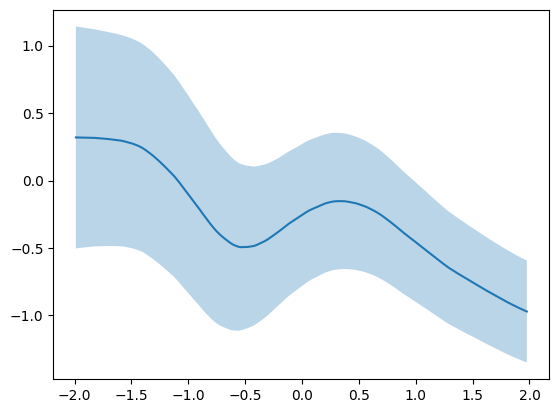

In [62]:
plot_mean_with_std(X, mean=MEAN, std=STD)